# 文字探勘與共線性進行資料視覺化

In [ ]:
#### import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode
import plotly.offline as offline
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import rgb2hex
import re
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
import networkx as nx
import matplotlib.pyplot as plt
import codecs
init_notebook_mode(connected=False)

# 1. 匯入金融字典

In [65]:
a_file = open("dsimple.txt", "r")
edic=[]
for line in a_file:
    stripped_line = line.strip()
    x=stripped_line.split(' ')
    for l in x:
        if l.encode( 'UTF-8' ).isalpha():
            edic.append(l)


# 2. 刪除停用詞、檢查單字是否存於字典中

In [60]:
wordnet_lemmatizer = WordNetLemmatizer()
stop = stopwords.words('english')

def isSymbol(inputString):
    return bool(re.match(r'[^\w]', inputString))

def check(word,edic):
    word= word.lower()
    if word in stop:
        return False
    elif  isSymbol(word):
        return False
    elif  word not in edic:
        return False
    else:
        return True

def preprocessing(word,edic):
    if check(word,edic):
        return word


# 3. 載入新聞

In [8]:
survey_df = pd.read_csv('/Users/chenjessie/Desktop/中信/News-crawler-master/BillAckman.csv')
survey_df.head()

,Title,Year,Month,Day,Content,Href_link
0,Activist investors are set to capitali...,2020,4,18,"From 2007 through 2019, I wrote the weekly Ac...",https://www.cnbc.com/2020/04/18/activist-inves...
1,"Stock market live Monday: Dow rises 1,...",2020,4,6,Stocks ripped higher to start the holiday-sho...,https://www.cnbc.com/2020/04/06/stock-market-l...
2,Bill Ackman says accusations he tried ...,2020,3,27,Pershing Square Capital manager Bill Ackman d...,https://www.cnbc.com/2020/03/27/bill-ackman-sa...
3,Bill Ackman warned 'hell is coming' be...,2020,3,25,Pershing Square manager Bill Ackman turned a ...,https://www.cnbc.com/2020/03/25/bill-ackman-ex...
4,Dow rises more than 100 points in rebo...,2020,3,18,"Stocks closed higher Thursday, erasing steep ...",https://www.cnbc.com/2020/03/18/dow-futures-op...


# 4. 判斷詞性、是否存在金融字典中

In [155]:
data_vb = []
data_nn = []
data_jj = []
data_dic = []
data_total=[]
for i in range(len(survey_df['Content'])):
    sent_tokens = sent_tokenize(survey_df['Content'][i])
    for j in sent_tokens:
        w = word_tokenize(j)
        tag=pos_tag(w)
        s_vb = []
        s_nn = []
        s_jj = []
        for item in tag:
            x = list(item)
            if x[1] == ('VB'or 'VBN' or 'VBG'):
                s_vb.append(x[0])
            elif x[1] == ('NN'or 'NNS'):
                s_nn.append(x[0])
            elif x[1] == 'JJ':
                s_jj.append(x[0])
        s_dic = [preprocessing(xx,edic) for xx in w]
        data_vb.append(s_vb)
        data_nn.append(s_nn)
        data_jj.append(s_jj)
        data_dic.append(s_dic)
        t = s_vb + s_dic + s_jj
        data_total.append(t)
print(len(data_vb))
print(len(data_nn))
print(len(data_jj))
print(len(data_dic))
print(len(data_total))

7200
7200
7200
7200
7200


# 5. TDM

In [134]:
data = data_total

In [156]:
names = {}          
relationships = {}  
lineNames = []  
for i in range(len(data)):
    try:
        poss = data[i]
        lineNames.append([])
        for w in poss:
            if w != None:
                if w not in stop:
                    lineNames[-1].append(w)        
                if names.get(w) is None and w not in stop:    
                    relationships[w] = {}            
    except:
        pass

In [157]:
term_dic = dict()
for sentence in lineNames:
    for term in sentence:
        if term not in term_dic:
            term_dic[term] = {}

In [158]:
for i in range(len(lineNames)):
    for term1 in term_dic:
        num = 0
        for term2 in lineNames[i]:
            if term1 == term2:
                num += 1
        term_dic[term1][str(i)] = num

In [138]:
TDM = pd.DataFrame.from_dict(term_dic)
TDM.head()

,start,create,close,company,Bill,value,wait,recognize,flourish,market,...,probe,sign,perpetuate,commerce,verify,forecast,spare,assail,PwC,wonder
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,1,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 6. Co-Occurrence Matrix¶

In [159]:
names = {}          
relationships = {}  
lineNames = []     

for i in range(len(data)):
    try:
        poss = data[i]
        lineNames.append([])
        for w in poss:
            if w != None:
                lineNames[-1].append(w)        
                if names.get(w) is None :
                    names[w] = 0
                    relationships[w] = {}
                    names[w] += 1   
    except:
        pass

for line in lineNames:                  
    for name1 in line:                  
        for name2 in line:             
            if name1 == name2:
                continue
            if relationships[name1].get(name2) is None:     
                relationships[name1][name2]= 1
            else:
                relationships[name1][name2] = relationships[name1][name2]+ 1       
co_occur_by_records = [[name, v, w] for name, edges in relationships.items() for v, w in edges.items() if w > 15]

In [160]:
np.random.shuffle(co_occur_by_records)
temp_matrix = pd.DataFrame()
for i in co_occur_by_records:
    temp_matrix.at[i[0], i[1]] = i[2]
co_occurrence_matrix_by_records = pd.DataFrame()
for i in temp_matrix:
    for j in temp_matrix:
        co_occurrence_matrix_by_records.at[i, j] = temp_matrix.at[i, j]
#co_occurrence_matrix_by_records.head()

In [161]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))
count_by_records = [i[2] for i in co_occur_by_records]
co_occur_by_records_sig = []
for i in co_occur_by_records:
    co_occur_by_records_sig.append([i[0], i[1], sigmoid((i[2] - np.mean(count_by_records))/np.std(count_by_records))])

# 7. 共現圖

# (1) 金融字典＋動/形容詞

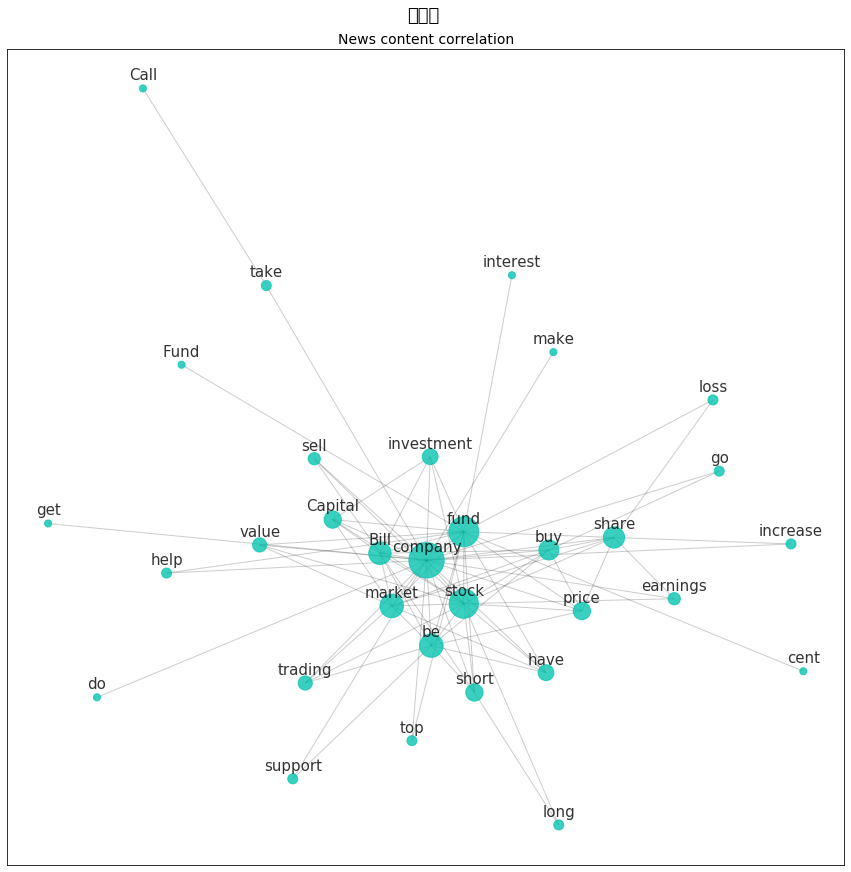

In [162]:
plt.figure(figsize=(15,15))
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['font.family']='sans-serif'
g = nx.Graph()
g.add_weighted_edges_from(co_occur_by_records_sig)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.8,node_size=[val*50 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, node_color='b', alpha=0.2)
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 15,  font_family='sans-serif',alpha=0.8)
plt.title('News content correlation', size = 14)
plt.suptitle('共線圖',x = 0.51,y=0.92, fontsize=18)
#plt.savefig("用詞共線圖_以每筆通聯紀錄為一句.png", dpi=100)
plt.show()

# ( 2 ) 動/名/形容詞

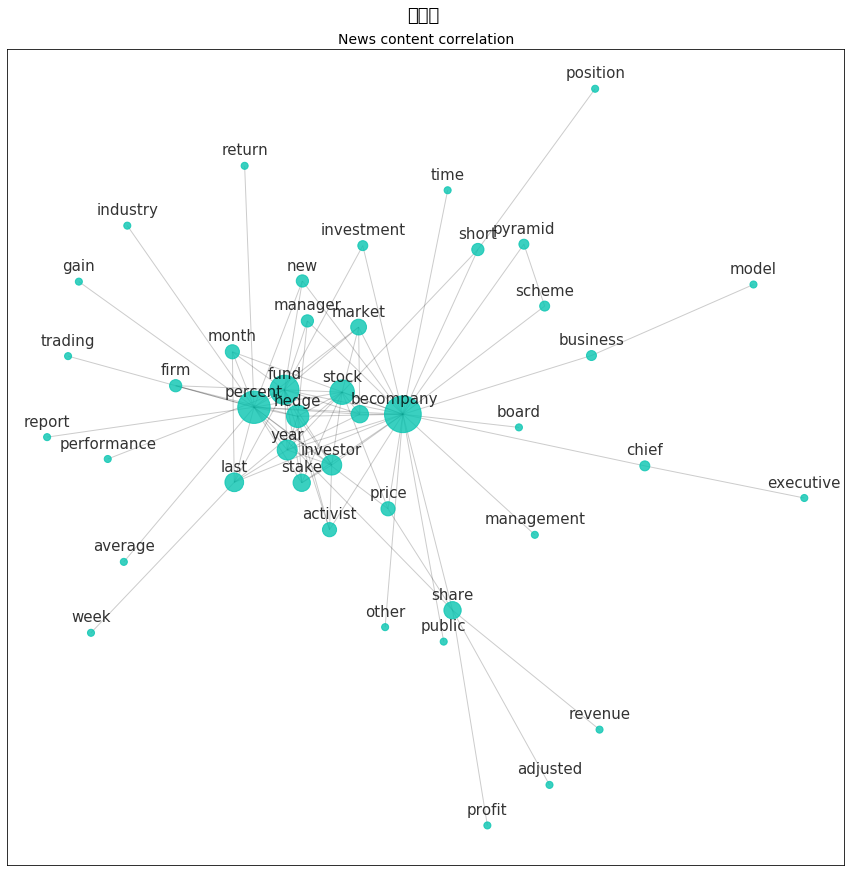

In [57]:
plt.figure(figsize=(15,15))
plt.rcParams['font.sans-serif'] = ['SimHei']   
plt.rcParams['font.family']='sans-serif'
g = nx.Graph()
g.add_weighted_edges_from(co_occur_by_records_sig)
pos=nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, alpha=0.8,node_size=[val*50 for (node, val) in g.degree()], node_color='#08c5b1')
nx.draw_networkx_edges(g, pos, node_color='b', alpha=0.2)
for p in pos:  # raise text positions
    pos[p][1] = pos[p][1] + 0.03
nx.draw_networkx_labels(g, pos, font_size = 15,  font_family='sans-serif',alpha=0.8)
plt.title('News content correlation', size = 14)
plt.suptitle('共線圖',x = 0.51,y=0.92, fontsize=18)
#plt.savefig("用詞共線圖_以每筆通聯紀錄為一句.png", dpi=100)
plt.show()

# 8. 熱度圖

#  金融字典＋動/形容詞

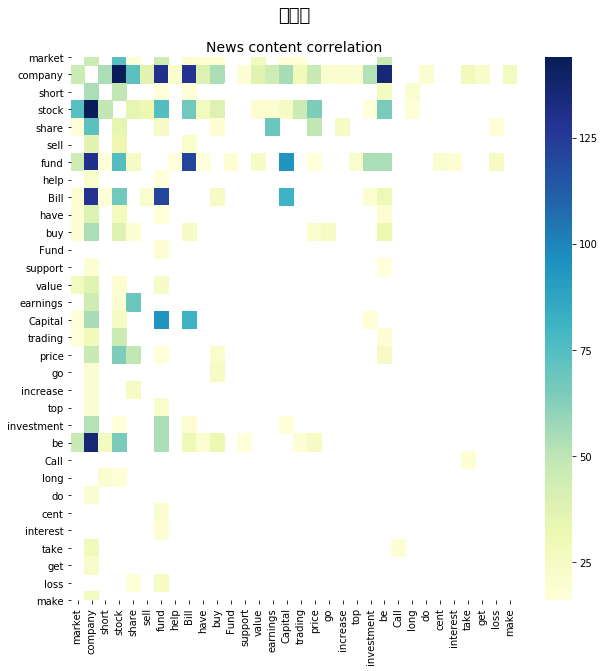

In [163]:
import seaborn as sn
plt.figure(figsize=(10,10))
sn.heatmap(co_occurrence_matrix_by_records,cmap='YlGnBu')
plt.title('News content correlation', size = 14)
plt.suptitle('熱度圖',x = 0.435,y=0.95, fontsize=18)
#plt.savefig("images/用詞熱度圖_以每筆通聯紀錄為一句.png", dpi=100)
plt.show()